# Comparison of causal and non-causal versions of model 1 on every second cell dataset

From notebook 11, model 1 appeared to be the best (or at least very similiar to model 2). Notebook 12 compared different methods of data input and found inputting every second range cell to be equal to or better than feeding in all the data.

This notebook is used to investigate a causal and non-causal version of model 1 with the every second range cell input.

As there are only two experiments, the number of epochs have also been increased.

## Notebook setup

In [1]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2
%matplotlib inline

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [5]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
#     !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
    
DATA_PATH_MTI = BASE_PATH + 'data/processed/range_FFT/3/MTI_applied/' # not used
DATA_PATH_NO_MTI = BASE_PATH + 'data/processed/range_FFT/3/MTI_not_applied/'

RESULTS_PATH = BASE_PATH + 'results/range_data_model_causal_vs_non_causal/'
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
    
MODEL_PATH = BASE_PATH + 'models/range_data_model_causal_vs_non_causal/'
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [6]:
from keras import backend as K 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras.callbacks import CSVLogger
from keras.utils import Sequence, to_categorical
from keras.layers import Input, Conv1D, Multiply, Add, Activation, AveragePooling1D, Flatten, Dense
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint
import sys

Using TensorFlow backend.


In [7]:
OVERWRITE_RESULTS = False
OVERWRITE_GRAPHS = True

## Data Setup

In [5]:
# Load in data dictionary.
# This does not load in any actual data,
# just the dictionary with the names of the files and their associated labels
with open(DATA_PATH_NO_MTI + "index.pkl", "rb") as file:
    data = pickle.load(file)

In [6]:
# Remove user C as this user is reserved for the test set
try:
    del data["C"]
except KeyError:
    print ("Key 'C' not found")

In [7]:
def convert_label_to_int(label):
    if label == "walking":
        return 0
    if label == "pushing":
        return 1
    if label == "sitting":
        return 2
    if label == "pulling":
        return 3
    if label == "circling":
        return 4
    if label == "clapping":
        return 5
    if label == "bending":
        return 6

In [8]:
labels = {}
partition = {'train': [], 'validation': []}  # contains list of training and validation ID's
validation_user = "B"  # use user B for validation

for user_letter, actions in data.items():
    for action, results in actions.items():
        for result in results:
            for row in result:
                if user_letter == validation_user:
                    partition["validation"].append(row)
                    labels[row] = convert_label_to_int(action)

                else:
                    partition["train"].append(row)
                    labels[row] = convert_label_to_int(action)

In [8]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

## DataGenerator

In [10]:
'''Based on code from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly'''

class DataGenerator(Sequence):
    """Generates data for Keras"""
    def __init__(self, list_IDs, labels, batch_size=32, dim=(3000),
                 n_classes=7, shuffle=False, data_directory='data/',
                 bin_range=(0,60), take_average=False, every_second_cell=False):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data_directory = data_directory
        self.bin_range=bin_range
        self.take_average = take_average
        self.every_second_cell = every_second_cell
        self.indexes = None
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization
        X = np.empty((self.batch_size, *self.dim))

        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.take_average:
                X[i,] = abs(np.average(np.load(self.data_directory + ID), axis=1)[:,np.newaxis])
                
            elif self.every_second_cell:
                X[i,] = abs(np.load(self.data_directory + ID))[:,::2]
                
            else:
                X[i,] = abs(np.load(self.data_directory + ID))[:,self.bin_range[0]:self.bin_range[1]]
                
            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes)

## Function to aid the exploration of models.

In [11]:
def test_model(model, training_generator, validation_generator,
               epochs, csvlog_path, verbose=True, load_weights=False, weights_path=''):
    # Generators

    
    weights_path = MODEL_PATH + weights_path

    start_epoch = 0
    if load_weights:
        model = load_model(weights_path)
        last_epoch = weights_path.split("-")[-3]
        start_epoch = int(last_epoch)
        
    model_path = csvlog_path.split(".")[-2] # remove the .csv
    if not load_weights:
        model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    checkpoint = ModelCheckpoint(MODEL_PATH + model_path + "_epoch-{epoch:02d}-{val_acc:.2f}.hdf5",
                                 monitor='val_acc', verbose=0, save_best_only=False,
                                 save_weights_only=False, mode='auto', period=1)

    csv_logger = CSVLogger(RESULTS_PATH + csvlog_path, append=True)
    callbacks_list = [checkpoint, csv_logger]
    # Train model on dataset
    model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        use_multiprocessing=False,
                        workers=1,
                        epochs=epochs,
                        callbacks=callbacks_list,
                        initial_epoch=start_epoch,
                        verbose=verbose)

### Visualize Results

In [12]:
def visualize_results(csvlog_path, title, save=False, save_file_name=""):
    df = pd.read_csv(RESULTS_PATH + csvlog_path)
    epoch = df['epoch'] + 1
    train = df["acc"] * 100  # convert to %
    val = df['val_acc'] * 100  # convert to %
    plt.figure()
    plt.plot(epoch, train, 'b--', marker='x', label='Training (Subjects A, D, E and F)')
    plt.plot(epoch, val, 'r-', marker='x', label='Validation (Subject B)')
    plt.xticks(epoch)
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Classification Accuracy (%)')
    plt.grid()
    plt.title(title)
    if save:
        plt.savefig(RESULTS_PATH + save_file_name, format='pdf')
    plt.show()

In [13]:
def plot_loss(csvlog_path, title, save=False, save_file_name=""):
    df = pd.read_csv(RESULTS_PATH + csvlog_path)
    epoch = df['epoch'] +1
    train = df["loss"]
    val = df['val_loss']
    plt.figure()
    plt.plot(epoch, train, 'b--', marker='x', label='Training (Subjects A, D, E and F)')
    plt.plot(epoch, val, 'r-', marker='x', label='Validation (Subject B)')
    plt.xticks(epoch)
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.title(title)
    if save:
        plt.savefig(RESULTS_PATH + save_file_name, format='pdf')
    plt.show()

## Model 1: Wavenet model adapted based on interpretation from Wavenet Paper

Keras implementation of wavenet model taken from https://github.com/basveeling/wavenet and https://github.com/mjpyeon/wavenet-classifier

This model has then been adapted to the classification task based on the intrustions from the paper "WAVENET: A GENERATIVE MODEL FOR RAW AUDIO" (https://arxiv.org/pdf/1609.03499.pdf)

Specifically:
"For this task we added a mean-pooling layer after the dilated convolutions that aggregated the activations to coarser frames spanning 10 milliseconds (160× downsampling).  The pooling layer was followed by a few non-causal convolutions."

In [14]:
class WaveNetClassifier:
    def __init__(self, input_shape, output_shape, kernel_size=2, dilation_depth=9, nb_stacks=1, nb_filters=40,
                 pool_size_1=80, pool_size_2=100, use_skip_connections=True, causal=True):

        self.activation = 'softmax'
        self.pool_size_1 = pool_size_1
        self.pool_size_2 = pool_size_2
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.dilation_depth = dilation_depth
        self.nb_filters = nb_filters
        self.use_skip_connections = use_skip_connections
        self.input_shape = input_shape
        self.output_shape = output_shape
        if causal:
            self.padding = 'causal'
        else:
            self.padding = 'same'

        if len(input_shape) == 1:
            self.expand_dims = True
        elif len(input_shape) == 2:
            self.expand_dims = False
        else:
            print('ERROR: wrong input shape')
            sys.exit()

        self.model = self.build_model()

    def residual_block(self, x, i, stack_nb):
        original_x = x
        tanh_out = Conv1D(self.nb_filters, self.kernel_size, dilation_rate=2 ** i, padding=self.padding,
                          name='dilated_conv_%d_tanh_s%d' % (2 ** i, stack_nb), activation='tanh')(x)
        sigm_out = Conv1D(self.nb_filters, self.kernel_size, dilation_rate=2 ** i, padding=self.padding,
                          name='dilated_conv_%d_sigm_s%d' % (2 ** i, stack_nb), activation='sigmoid')(x)
        x = Multiply(name='gated_activation_%d_s%d' % (i, stack_nb))([tanh_out, sigm_out])

        res_x = Conv1D(self.nb_filters, 1, padding='same')(x)
        skip_x = Conv1D(self.nb_filters, 1, padding='same')(x)
        res_x = Add()([original_x, res_x])
        return res_x, skip_x

    def build_model(self):
        input_layer = Input(shape=self.input_shape, name='input_part')
        out = input_layer
        skip_connections = []
        out = Conv1D(self.nb_filters, self.kernel_size,
                     dilation_rate=1,
                     padding=self.padding,
                     name='initial_causal_conv'
                     )(out)
        for stack_nb in range(self.nb_stacks):
            for i in range(0, self.dilation_depth + 1):
                out, skip_out = self.residual_block(out, i, stack_nb)
                skip_connections.append(skip_out)

        if self.use_skip_connections:
            out = Add()(skip_connections)
        out = Activation('relu')(out)
        # added a mean-pooling layer after the dilated convolutions that aggregated the activations to coarser frames
        # spanning 10 milliseconds (160× downsampling)
        # mean pooling layer adjust pool_size_1 to change downsampling
                
        out = AveragePooling1D(self.pool_size_1, padding='same', name='mean_pooling_layer_downsampling')(out)

        # few non-causal convolutions
        '''
        *Update 15/02/2019*
        I have now realized that self.pool_size_1 and self.pool_size_2 actually represent kernel size here.
        Due to the length of time this notebook takes to run and as the values set worked this will not be rerun
        but has been updated in notebook 13 conducting the regularization investigation.
        '''
        # 

        out = Conv1D(self.nb_filters, self.pool_size_1, strides=2, padding='same', activation='relu')(out)
        out = Conv1D(self.nb_filters, self.pool_size_2, strides=2, padding='same', activation='relu')(out)
        out = Conv1D(self.output_shape, self.pool_size_2, strides=2, padding='same', activation='relu')(out)
        out = Conv1D(self.output_shape, self.pool_size_2, strides=2, padding='same', activation='relu')(out)


        out = Flatten()(out)
        out = Dense(512, activation='relu')(out)
        out = Dense(self.output_shape, activation='softmax')(out)

        return Model(input_layer, out)

    def get_model(self):
        return self.model

    def get_summary(self):
        self.model.summary()

    def get_receptive_field(self):
        k = self.kernel_size
        n = self.dilation_depth
        s = self.nb_stacks
        r_s = k + (2*(k-1)*((2**(n-1))-1))  # receptive field for one stack
        return (s*r_s) - (s-1)  # total receptive field for 's' number of stacks


## Fixed Parameters

In [15]:
# Try all bins to start with
bin_range = (0, 63)
data_shape = (3000, 32)
n_filters = 64
activation = 'softmax'
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
batch_size = 16
epochs = 10
dilation_depth = 8
nb_stacks = 3

# Parameters for data generators
params = {'dim': data_shape,
          'batch_size': batch_size,
          'n_classes': nb_classes,
          'data_directory': DATA_PATH_NO_MTI,
          'bin_range': bin_range,
          'every_second_cell': True}

## Causal

In [16]:
wnc = WaveNetClassifier((data_shape), (nb_classes), kernel_size=kernel_size,
                        dilation_depth=dilation_depth, nb_stacks=nb_stacks,
                        nb_filters=n_filters,
                        pool_size_1=pool_size_1, pool_size_2=pool_size_2)

wnc.build_model()
model = wnc.get_model()

training_generator = DataGenerator(partition['train'], labels, **params, shuffle=True)
validation_generator = DataGenerator(partition['validation'], labels, **params, shuffle=False)
csvlog_path = "causal.csv"
if OVERWRITE_RESULTS:
    test_model(model, training_generator, validation_generator, epochs, csvlog_path, verbose=True)

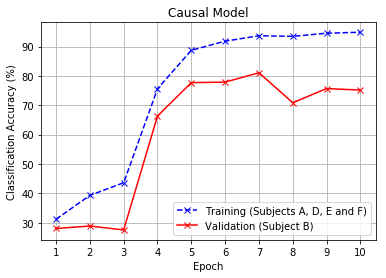

In [17]:
save_graph_path = csvlog_path.split('.')[-2] + ".pdf"
visualize_results(csvlog_path, "Causal Model", save=OVERWRITE_GRAPHS, save_file_name=save_graph_path)

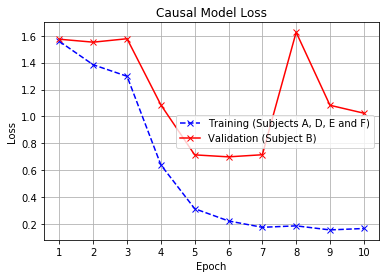

In [18]:
plot_loss(csvlog_path, "Causal Model Loss")

In [19]:
K.clear_session()

## Non-Causal

In [20]:
wnc = WaveNetClassifier((data_shape), (nb_classes), kernel_size=kernel_size,
                        dilation_depth=dilation_depth, nb_stacks=nb_stacks,
                        nb_filters=n_filters,
                        pool_size_1=pool_size_1, pool_size_2=pool_size_2, causal=False)

wnc.build_model()
model = wnc.get_model()

training_generator = DataGenerator(partition['train'], labels, **params, shuffle=True)
validation_generator = DataGenerator(partition['validation'], labels, **params, shuffle=False)
csvlog_path = "non_causal.csv"
if OVERWRITE_RESULTS:
    test_model(model, training_generator, validation_generator, epochs, csvlog_path, verbose=True)

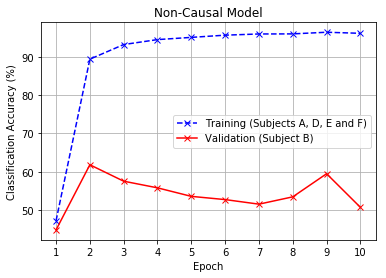

In [21]:
save_graph_path = csvlog_path.split('.')[-2] + ".pdf"
visualize_results(csvlog_path, "Non-Causal Model", save=OVERWRITE_GRAPHS, save_file_name=save_graph_path)

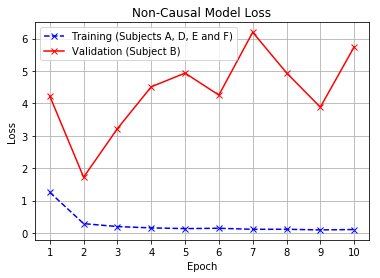

In [22]:
plot_loss(csvlog_path, "Non-Causal Model Loss")

In [31]:
K.clear_session()

From the two graphs it is clear that the causal model outperforms the non-causal. It also shows that overfitting is a clear issue. To combat this, early stopping will be utilized.

The results were surprising as the non-causal model was expected to perform better. The causal vs non-causal was compared again with a reduced 

## Smaller Dilation Comparison

When constructing the notebook for conducting the hyperparameter search it was found that the pooling sizes referred to in the model (pool size 1 and pool size 2) were actually kernel sizes. This has been updated in the following model.

In [15]:
class WaveNetClassifier:
    def __init__(self, input_shape, output_shape, kernel_size=2, dilation_depth=9, nb_stacks=1, nb_filters=40,
                 pool_size=80, kernel_size_2=4, num_dense_nodes=512, use_skip_connections=True, causal=True):

        self.activation = 'softmax'
        self.pool_size = pool_size
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size # for dilated layers
        self.kernel_size_2 = kernel_size_2 # for normal conv layers at end
        self.dilation_depth = dilation_depth
        self.nb_filters = nb_filters
        self.num_dense_nodes = num_dense_nodes
        self.use_skip_connections = use_skip_connections
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        if causal:
            self.padding = 'causal'
        else:
            self.padding = 'same'

        if len(input_shape) == 1:
            self.expand_dims = True
        elif len(input_shape) == 2:
            self.expand_dims = False
        else:
            print('ERROR: wrong input shape')
            sys.exit()

        self.model = self.build_model()

    def residual_block(self, x, i, stack_nb):
        original_x = x
        tanh_out = Conv1D(self.nb_filters, 2, dilation_rate=2 ** i, padding=self.padding,
                          name='dilated_conv_%d_tanh_s%d' % (2 ** i, stack_nb), activation='tanh')(x)
        sigm_out = Conv1D(self.nb_filters, 2, dilation_rate=2 ** i, padding=self.padding,
                          name='dilated_conv_%d_sigm_s%d' % (2 ** i, stack_nb), activation='sigmoid')(x)
        x = Multiply(name='gated_activation_%d_s%d' % (i, stack_nb))([tanh_out, sigm_out])

        res_x = Conv1D(self.nb_filters, 1, padding='same')(x)
        skip_x = Conv1D(self.nb_filters, 1, padding='same')(x)
        res_x = Add()([original_x, res_x])
        return res_x, skip_x

    def build_model(self):
        input_layer = Input(shape=self.input_shape, name='input_part')
        out = input_layer
        skip_connections = []
        out = Conv1D(self.nb_filters, 2,
                     dilation_rate=1,
                     padding=self.padding,
                     name='initial_causal_conv'
                     )(out)
        for stack_nb in range(self.nb_stacks):
            for i in range(0, self.dilation_depth + 1):
                out, skip_out = self.residual_block(out, i, stack_nb)
                skip_connections.append(skip_out)

        if self.use_skip_connections:
            out = Add()(skip_connections)
        out = Activation('relu')(out)
        # added a mean-pooling layer after the dilated convolutions that aggregated the activations to coarser frames
        # spanning 10 milliseconds (160× downsampling)
        # mean pooling layer adjust pool_size to change downsampling
        out = AveragePooling1D(self.pool_size, padding='same', name='mean_pooling_layer_downsampling')(out)

        # few non-causal convolutions
        # In notebooks 11, 12 and 13 self.kernel_size_2 was incorrectly represented as pooling sizes.
        out = Conv1D(self.nb_filters, self.kernel_size_2, strides=2, padding='same', activation='relu')(out)
        out = Conv1D(self.nb_filters, self.kernel_size_2, strides=2, padding='same', activation='relu')(out)
        out = Conv1D(self.output_shape, self.kernel_size_2, strides=2, padding='same', activation='relu')(out)
        out = Conv1D(self.output_shape, self.kernel_size_2, strides=2, padding='same', activation='relu')(out)


        out = Flatten()(out)
        out = Dense(self.num_dense_nodes, activation='relu')(out)
        out = Dense(self.output_shape, activation='softmax')(out)

        return Model(input_layer, out)

    def get_model(self):
        return self.model

    def get_summary(self):
        self.model.summary()

    def get_receptive_field(self):
        k = self.kernel_size
        n = self.dilation_depth
        s = self.nb_stacks
        r_s = k + (2*(k-1)*((2**(n-1))-1))  # receptive field for one stack
        return (s*r_s) - (s-1)  # total receptive field for 's' number of stacks

In [16]:
dilation_depth = 8
nb_stacks = 1
pool_size = 4
kernel_size_2 = 8
num_dense_nodes = 512  # same as before

## Causal v2

In [17]:
wnc = WaveNetClassifier((data_shape), (nb_classes), kernel_size=kernel_size,
                        dilation_depth=dilation_depth, nb_stacks=nb_stacks,
                        nb_filters=n_filters,
                        pool_size=pool_size, kernel_size_2=kernel_size_2,
                        num_dense_nodes=num_dense_nodes)

wnc.build_model()
model = wnc.get_model()

training_generator = DataGenerator(partition['train'], labels, **params, shuffle=True)
validation_generator = DataGenerator(partition['validation'], labels, **params, shuffle=False)
csvlog_path = "causal_v2.csv"
if OVERWRITE_RESULTS:
    test_model(model, training_generator, validation_generator, epochs, csvlog_path, verbose=True)

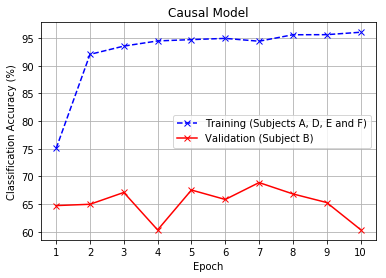

In [18]:
save_graph_path = csvlog_path.split('.')[-2] + ".pdf"
visualize_results(csvlog_path, "Causal Model", save=OVERWRITE_GRAPHS, save_file_name=save_graph_path)

In [ ]:
K.clear_session()

## Non-Causal v2

In [19]:
wnc = WaveNetClassifier((data_shape), (nb_classes), kernel_size=kernel_size,
                        dilation_depth=dilation_depth, nb_stacks=nb_stacks,
                        nb_filters=n_filters,
                        pool_size=pool_size, kernel_size_2=kernel_size_2,
                        num_dense_nodes=num_dense_nodes, causal=False)

wnc.build_model()
model = wnc.get_model()

training_generator = DataGenerator(partition['train'], labels, **params, shuffle=True)
validation_generator = DataGenerator(partition['validation'], labels, **params, shuffle=False)
csvlog_path = "non_causal_v2.csv"
if OVERWRITE_RESULTS:
    test_model(model, training_generator, validation_generator, epochs, csvlog_path, verbose=True)

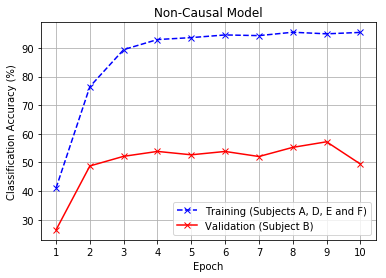

In [20]:
save_graph_path = csvlog_path.split('.')[-2] + ".pdf"
visualize_results(csvlog_path, "Non-Causal Model", save=OVERWRITE_GRAPHS, save_file_name=save_graph_path)

As shown, the causal model appears to still outperform the non-causal. Both versions appear to suffer signifcantly from overfitting for later epochs. This is addressed by regularization techniques investigated in notebook 14.

# Combined Graphs

In [9]:
causal = pd.read_csv(RESULTS_PATH + "causal.csv")
non_causal = pd.read_csv(RESULTS_PATH + "non_causal.csv")
causal_v2 = pd.read_csv(RESULTS_PATH + "causal_v2.csv")
non_causal_v2 = pd.read_csv(RESULTS_PATH + "non_causal_v2.csv")

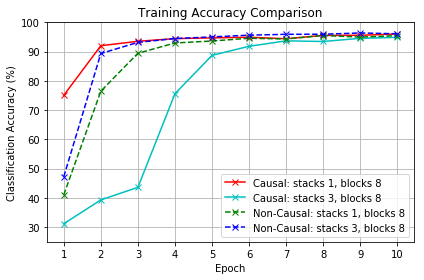

In [20]:
epochs = causal['epoch'] + 1
plt.plot(epochs, causal_v2['acc'] * 100, 'r', label="Causal: stacks 1, blocks 8", marker='x')
plt.plot(epochs, causal['acc'] * 100, 'c', label="Causal: stacks 3, blocks 8", marker='x')
plt.plot(epochs, non_causal_v2['acc'] * 100, 'g--', label="Non-Causal: stacks 1, blocks 8", marker='x')
plt.plot(epochs, non_causal['acc'] * 100, 'b--', label="Non-Causal: stacks 3, blocks 8", marker='x')
# plt.plot(epochs, cell_30['val_acc'] * 100, 'b', label="Cell 30", marker='x')
# plt.plot(epochs, cell_62['val_acc'] * 100, 'r', label="Cell 62", marker='x')
# plt.plot(epochs, every_second['val_acc'] * 100, 'g', label="Every second cell", marker='x')
plt.xticks(epochs)
plt.ylim((25, 100))

plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy (%)")
plt.title("Training Accuracy Comparison")

plt.grid(True)
plt.legend()

plt.tight_layout()
if OVERWRITE_GRAPHS:
    plt.savefig(RESULTS_PATH + 'train_acc.pdf', format='pdf')

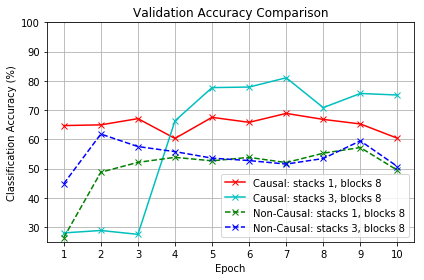

In [21]:
epochs = causal['epoch'] + 1
plt.plot(epochs, causal_v2['val_acc'] * 100, 'r', label="Causal: stacks 1, blocks 8", marker='x')
plt.plot(epochs, causal['val_acc'] * 100, 'c', label="Causal: stacks 3, blocks 8", marker='x')
plt.plot(epochs, non_causal_v2['val_acc'] * 100, 'g--', label="Non-Causal: stacks 1, blocks 8", marker='x')
plt.plot(epochs, non_causal['val_acc'] * 100, 'b--', label="Non-Causal: stacks 3, blocks 8", marker='x')
# plt.plot(epochs, cell_30['val_acc'] * 100, 'b', label="Cell 30", marker='x')
# plt.plot(epochs, cell_62['val_acc'] * 100, 'r', label="Cell 62", marker='x')
# plt.plot(epochs, every_second['val_acc'] * 100, 'g', label="Every second cell", marker='x')
plt.xticks(epochs)
plt.ylim((25, 100))

plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy (%)")
plt.title("Validation Accuracy Comparison")

plt.grid(True)
plt.legend()

plt.tight_layout()
if OVERWRITE_GRAPHS:
    plt.savefig(RESULTS_PATH + 'val_acc.pdf', format='pdf')